# Imports

In [165]:
import zipfile
import numpy as np
import pandas as pd
import os
import tqdm
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt

# Download data from Kaggle

In [ ]:
! pip install kaggle --upgrade

In [3]:
# get <token> from https://www.kaggle.com/<user>/account, click "Create New API Token", open json file
! KAGGLE_USERNAME=<user> KAGGLE_KEY=<token> kaggle competitions download -c quickdraw-doodle-recognition -f train_simplified.zip

100%|█████████████████████████████████████▉| 7.37G/7.37G [02:41<00:00, 85.0MB/s]
100%|██████████████████████████████████████| 7.37G/7.37G [02:41<00:00, 48.9MB/s]


In [60]:
# extract data
zf = zipfile.ZipFile("train_simplified.zip")
zf.extractall(path="./data")
zf.close()

# Data generators from disk (no need to store in RAM)

In [118]:
class_labels = map(lambda x: x.replace(".csv", ""), os.listdir("./data"))
class_labels[:5]

['golf club', 'popsicle', 'church', 'camera', 'mermaid']

In [150]:
# loop through file eternally
def get_eternal_csv_generator(fn, debug=False):
    while True:
        with open(fn, "r", buffering=4*1024*1024) as f:
            f.readline()  # skip header
            for line in csv.reader(f, delimiter=',', quotechar='"'):
                yield line[1], line[5]
            if debug:
                print fn, "is done, starting from the beginning..."

In [151]:
# test
gen = get_eternal_csv_generator("./data/yoga.csv", debug=True)
for line in tqdm.tqdm_notebook(gen):
    pass

./data/yoga.csv is done, starting from the beginning...
./data/yoga.csv is done, starting from the beginning...
./data/yoga.csv is done, starting from the beginning...
./data/yoga.csv is done, starting from the beginning...
./data/yoga.csv is done, starting from the beginning...
./data/yoga.csv is done, starting from the beginning...
./data/yoga.csv is done, starting from the beginning...
./data/yoga.csv is done, starting from the beginning...


KeyboardInterrupt: 

In [156]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator("./data/" + fn, debug) for fn in os.listdir("./data")])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        yield [gen.next() for gen in generators[random_indices]]

In [159]:
# test
for batch in tqdm.tqdm_notebook(raw_batch_generator(32, True)):
    if np.random.random() < 0.0001:
        print [e[1] for e in batch]

['pear', 'hand', 'bulldozer', 'vase', 'school bus', 'garden hose', 'saxophone', 'banana', 'passport', 'flashlight', 'star', 'foot', 'stereo', 'pencil', 'police car', 'ambulance', 'star', 'moon', 'belt', 'broccoli', 'hand', 'train', 'angel', 'bandage', 'wine bottle', 'flashlight', 'birthday cake', 'canoe', 'drums', 'dishwasher', 'couch', 'diving board']
['pig', 'hot dog', 'matches', 'pencil', 'monkey', 'saw', 'strawberry', 'line', 'triangle', 'drums', 'zebra', 'palm tree', 'belt', 'scissors', 'drill', 'blackberry', 'van', 'candle', 'palm tree', 'flower', 'tooth', 'violin', 'owl', 'hospital', 'mouth', 'pool', 'garden', 'rabbit', 'dragon', 'canoe', 'cow', 'stove']
['binoculars', 'cloud', 'tent', 'golf club', 'calculator', 'ambulance', 'shovel', 'flamingo', 'popsicle', 'duck', 'lion', 'hockey puck', 'scorpion', 'string bean', 'rain', 'garden', 'The Eiffel Tower', 'computer', 'flashlight', 'jacket', 'paper clip', 'stitches', 'traffic light', 'hat', 'whale', 'telephone', 'lollipop', 'mouse',

KeyboardInterrupt: 

# Images generator

In [189]:
# copy-paste from https://www.kaggle.com/jpmiller/image-based-cnn

import ast
from PIL import Image, ImageDraw

IMG_SIZE = 224

# faster conversion function
def draw_it(strokes):
    image = Image.new("P", (256, 256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    return np.array(image, dtype=np.uint8)

In [190]:
def images_and_labels_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

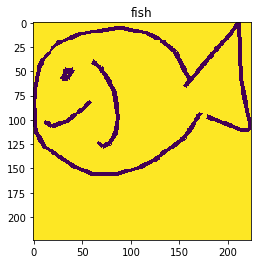

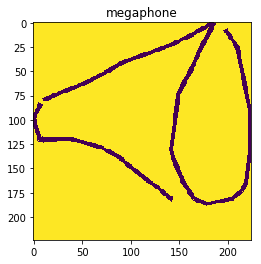

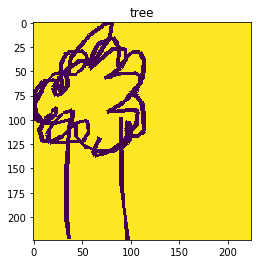

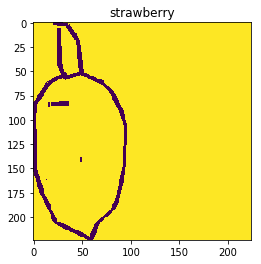

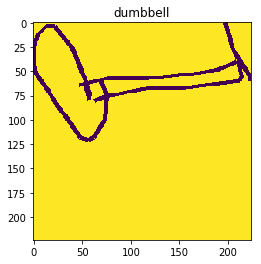

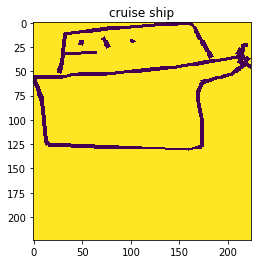

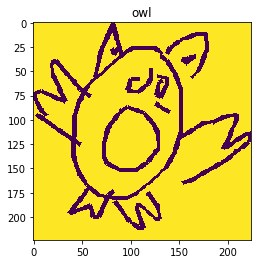

KeyboardInterrupt: 

In [191]:
# test
for batch in tqdm.tqdm_notebook(images_and_labels_generator(32)):
    if np.random.random() < 0.01:
        plt.imshow(batch[0][10, :, :])
        plt.title(batch[1][10])
        plt.show()